# Imports

In [1]:
import findspark
findspark.init()

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as functions

In [2]:
path_to_csv = './data/openfoods.csv'

# Init Spark Session and Load Data

In [3]:
spark = SparkSession.builder \
    .appName("KMeansClustering") \
    .config("spark.num.executors", "2") \
    .config("spark.executor.cores", "5") \
    .config("spark.executor.memory", "5g") \
    .config("spark.driver.memory", "5g") \
    .getOrCreate()

df = spark.read.csv(path_to_csv, header=True, sep='\t')
print(f'Number of columns: {len(df.columns)}')
print(f'Number of records: {df.count()}')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/02 13:05:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Number of columns: 203


Number of records: 2879048


# Clear Data for Clusterization

Drop columns, which are not meaningful for clustorization (system logs, URLs, etc.).

In [4]:
useles_columns = ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'last_modified_by',
                  'product_name', 'brands', 'brands_tags', 'countries', 'countries_en', 'countries_tags', 'states', 'states_tags', 'states_en',
                  'last_image_t', 'last_image_datetime', 'image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url',
                  'image_nutrition_url', 'image_nutrition_small_url']
df = df.drop(*useles_columns)

Calculate the number of NaNs in each column.


In [5]:
from pyspark.sql.functions import col,isnan, when, count
number_of_records = df.count()
nan_in_cols = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).first()

23/06/02 13:05:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Choose which fracture of NaNs will be non-acceptable for each column. 

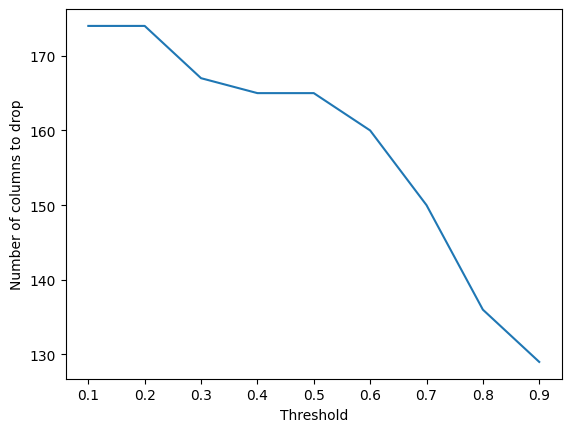

In [6]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_of_columns_to_drop = []
for threshold in thresholds:
    cols_to_drop = [c for c in nan_in_cols.asDict() if nan_in_cols[c] > number_of_records * threshold]
    num_of_columns_to_drop.append(len(cols_to_drop))

sns.lineplot(x=thresholds, y=num_of_columns_to_drop)
plt.xlabel('Threshold')
plt.ylabel('Number of columns to drop')
plt.show()

0.4 and 0.5 seems to be a good threshold values, since there is a plato in this range. So, we will pick 0.5.

In [7]:
cols_to_drop = [c for c in nan_in_cols.asDict() if nan_in_cols[c] > number_of_records * 0.5]
df = df.drop(*cols_to_drop)

Now we can drop rows with left nans.

In [8]:
# drop rows with null values
df = df.na.drop()
print(f'Number of columns: {len(df.columns)}')
print(f'Number of records: {df.count()}')
df.show(5)

Number of columns: 13


Number of records: 1879478
+--------------------+--------------+--------------+------------+----------------+-----------+--------+------------------+------------------+-----------+-------------+---------+-----------+
|       pnns_groups_1| pnns_groups_2|ecoscore_grade|completeness|energy-kcal_100g|energy_100g|fat_100g|saturated-fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|
+--------------------+--------------+--------------+------------+----------------+-----------+--------+------------------+------------------+-----------+-------------+---------+-----------+
|Milk and dairy pr...|Dairy desserts|             d|       0.575|              57|        238|     0.2|               0.1|               3.9|        3.9|           10|     0.09|      0.036|
|             unknown|       unknown|       unknown|       0.275|             375|       1569|       7|              3.08|              70.1|         15|          7.8|      1.4|       0.56|
|             unknown| 

# Features Preparation

Apply one-hot encodding to categorical variables.

In [9]:
from pyspark.sql import functions
from pyspark.ml.feature import StringIndexer

cat_cols = ['pnns_groups_1', 'pnns_groups_2', 'ecoscore_grade']

for col in cat_cols:
    distinct_values = df.select(col).distinct().collect()
    for val in distinct_values:
        df = df.withColumn("{}_{}".format(col, val), functions.when((df[col] == val[0]), 1).otherwise(0))

df = df.drop(*cat_cols)
df.show(5)

+------------+----------------+-----------+--------+------------------+------------------+-----------+-------------+---------+-----------+-------------------------------------------------------+------------------------------------------+-------------------------------------------------+--------------------------------------------+------------------------------------------------------+------------------------------------------------+--------------------------------------------------------+--------------------------------------------------+-----------------------------------------------+-------------------------------------------------+----------------------------------------------------------+-------------------------------------------+-----------------------------------------------------------+-------------------------------------------------------------------+---------------------------------------+------------------------------------------+--------------------------------------------

Create feature-vector for each record.

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import FloatType

df = df.select(
    *[functions.col(col).cast(FloatType()).alias(col) for col in df.columns]
)

vector_assemble = VectorAssembler(inputCols=df.columns, outputCol='features')
df = vector_assemble.transform(df)
df.select('features').show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                  |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(68,[0,1,2,3,4,5,6,7,8,9,20,52,63],[0.574999988079071,57.0,238.0,0.20000000298023224,0.10000000149011612,3.9000000953674316,3.9000000953674316,10.0,0.09000000357627869,0.035999998450279236,1.0,1.0,1.0])|
|(68,[0,1,2,3,4,5,6,7,8,9,11,25,61],[0.2750000059604645,375.0,1569.0,7.0,3.0799999237060547,70.0999984741211,15.0,7.800000190734863,1.399999976158142,0.5600000023841858,1.0,1.0,1.0

Apply StandardScaler to feature-vectors.

In [11]:
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
df = standard_scaler.fit(df).transform(df)  
df.select('scaled_features').show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                                                                                                                         |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(68,[0,1,2,3,4,5,6,7,8,9,20,52,63],[3.0131975389006866,0.11691740835571189,0.11589535872755023,2.74106

# Run KMeans clustering

In [12]:
from pyspark.ml.clustering import KMeans   


def run_kmeans(df, k):    
    kmeans = KMeans(featuresCol='scaled_features', k=k, seed=42)
    kmeans_fit = kmeans.fit(df)
    result = kmeans_fit.transform(df)
    return result

Choose best number of clusters (k).

In [13]:
from pyspark.ml.evaluation import ClusteringEvaluator


silhouette_scores = []

evaluator = ClusteringEvaluator(
    predictionCol='prediction',
    featuresCol='scaled_features',
    metricName='silhouette',
    distanceMeasure='squaredEuclidean'
)

for i in range(2, 10):
    result = run_kmeans(df, i)
    
    score = evaluator.evaluate(result)
    silhouette_scores.append(score)
    print('Silhouette Score for {} Clusters: {}'.format(i, score))
      

Silhouette Score for 2 Clusters: 0.9998995250066567


Silhouette Score for 3 Clusters: 0.7865758322041018


Silhouette Score for 4 Clusters: 0.46909244360184194


Silhouette Score for 5 Clusters: 0.467015194237454


Silhouette Score for 6 Clusters: 0.46911119971019144


Silhouette Score for 7 Clusters: 0.3295169063888125


Silhouette Score for 8 Clusters: 0.362657339839066


Silhouette Score for 9 Clusters: 0.4151433474648697


Range from 4-6 seems to be more stable. Let's see what PCA and UMAP will show.

Text(0, 0.5, 'Silhouette Score')

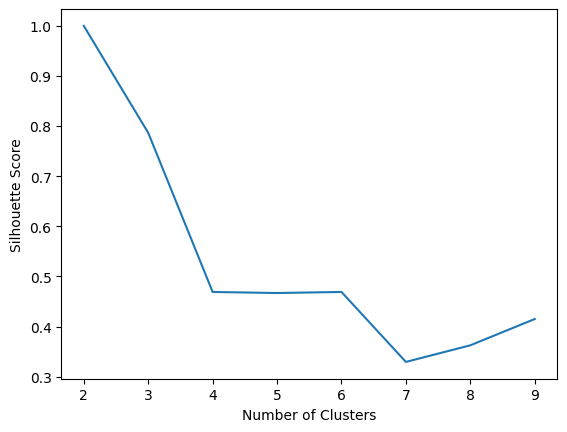

In [14]:
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Validation of Optimal Number of Clusters with PCA

In [15]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(k=5, inputCol="scaled_features", outputCol="pca")
model = pca.fit(df)
transformed = model.transform(df)

pca_1 = [point[0][0] for point in transformed.select('pca').collect()]
pca_2 = [point[0][1] for point in transformed.select('pca').collect()]

23/06/02 13:18:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/06/02 13:18:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Number of outliers: 116


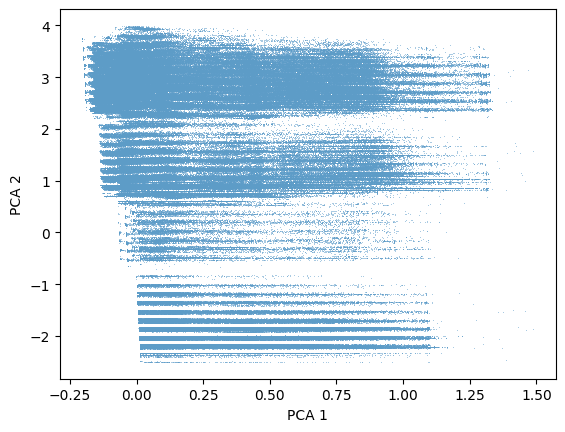

In [16]:
pca_1 = np.array(pca_1)
pca_2 = np.array(pca_2)

ids_without_outliers = np.where(np.array(pca_1) < 1.5)[0]
print(f'Number of outliers: {len(np.where(np.array(pca_1) > 1.5)[0])}')

sns.scatterplot(x=pca_1[ids_without_outliers], y=pca_2[ids_without_outliers], s=0.3)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

Distrinution along PCA 2 looks like 4 clusters.

# Validation of Optimal Number of Clusters with UMAP

Create dataframe of scaled features.

In [17]:
sf_df = df.rdd.map(lambda x:[float(y) for y in x['scaled_features']]).toDF()

Sample 0.1 of data for UMAP.

In [18]:
from pyspark import SparkContext as SparkContext

sample_df = sf_df.sample(0.1, 42).collect()

sc = SparkContext.getOrCreate()
sample_df = sc.parallelize(c=sample_df, numSlices=200)

sample_df=sample_df.toDF()

Convert data to pandas dataframe.

In [19]:
pandas_df = sample_df.toPandas()
print('Dataframe shape: {}'.format(pandas_df.shape))
pandas_df.head(5)

Dataframe shape: (188884, 68)


,_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,...,_59,_60,_61,_62,_63,_64,_65,_66,_67,_68
0,1.965129,0.065638,0.065252,0.000411,0.001144,0.066995,0.051510,0.012172,0.000006,0.000006,...,0.0,0.0,6.590955,0.000000,0.000000,0.0,0.0,0.0,3.597302,0.0
1,1.441095,0.322036,0.319930,0.028781,0.137266,0.492985,0.264156,0.105488,0.000021,0.000021,...,0.0,0.0,0.000000,2.246069,0.000000,0.0,0.0,0.0,0.000000,0.0
2,2.489163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,2.246069,0.000000,0.0,0.0,0.0,0.000000,0.0
3,2.030633,0.518949,0.515686,0.023299,0.029741,0.006320,0.006604,0.311053,0.000034,0.000034,...,0.0,0.0,0.000000,0.000000,5.051454,0.0,0.0,0.0,0.000000,0.0
4,1.965129,0.131276,0.130504,0.003152,0.026309,0.022753,0.018491,0.050039,0.000005,0.000005,...,0.0,0.0,6.590955,2.246069,0.000000,0.0,0.0,0.0,0.000000,0.0


Using UMAP to reduce dimensionality to 2D. Settings were chosen empirically.

In [20]:
import umap

fit = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
u = fit.fit_transform(pandas_df)

/usr/local/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

Plot UMAP results.

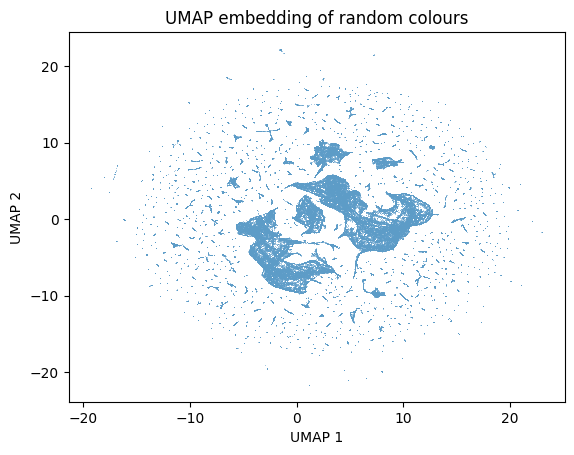

In [21]:
sns.scatterplot(x=u[:,0],y=u[:,1], s=0.3)
plt.title('UMAP embedding of random colours')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

Again, we can see 4 big clusters after dimensionality reduction. So, k=4 seems to be a good choice for KMeans.